In [2]:
import sys
sys.path.append("./../helper/") 
from common_imports import *
from helpers import *
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
YWINDOW = 10
YMIN = 1920
YMAX = 2020

### Load co-occurence counts

In [4]:
cc_soc = counter('../counting/wos-soc-limitedtitles-cooc')
cc_econ = counter('../counting/wos-econ-limitedtitles-cooc')

Loading ../counting/wos-soc-limitedtitles-cooc from disk...
Loading ../counting/wos-econ-limitedtitles-cooc from disk...


In [5]:
len(cc_soc.items('t')), len(cc_econ.items('t'))

(1000, 1000)

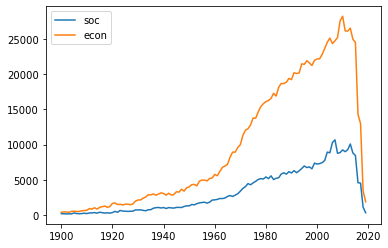

In [6]:
YS = range(1900,2020)
plt.plot(YS,
         [cc_soc(fy=y) for y in YS],
         label='soc'
);
plt.plot(YS,
         [cc_econ(fy=y) for y in YS],
         label='econ'
);
plt.legend();

### How surprising are co-occurrences given their marginal propsensities?

If terms are independent, their joint probability is $P(AB) = P(A)P(B)$. The ratio $\frac{P(AB)}{P(A)P(B)}$, therefore, is a good measure of surprisingness.

However, since we don't have probabilities but counts, we need to scale them by the total word count, $T$. Thus: 
$$\frac{\frac{C(AB)}{T}}{ \frac{C(A)}{T}\frac{C(B)}{T} } = \frac{C(AB)T}{C(A)C(B)}$$

### Calculate surprisingness ratio

In [7]:
cc_econ.tot = cc_econ.counts[('t',)].sum() # sum of counts across all terms
cc_soc.tot = cc_soc.counts[('t',)].sum() # sum of counts across all terms

cc_econ.terms = cc_econ.items('t') # all terms
cc_soc.terms = cc_soc.items('t') # all terms

In [8]:
def get_rat(counter, t1, t2, yfrom, yto):
    ca = sum( counter(t=t1, fy=y) for y in range(yfrom, yto) ) # count of t1
    cb = sum( counter(t=t2, fy=y) for y in range(yfrom, yto) ) # count of t2
    cab = sum( counter(t1=t1, t2=t2, fy=y) for y in range(yfrom, yto) ) # count of them appearing together
    #print(t1,t2,ca,cb,cab)

    if cab < 3 or ca < 3 or cb < 3:
        return 0

    rat = counter.tot * cab / (ca * cb) # surprise ratio
    return rat

# first determine the proper sample size

In [25]:
# lol... this doesn't make sense.
# I can't sample now. would have to do that *while counting*
scounts = []
for YY in range(YMIN, YMAX, YWINDOW):
    scount = sum( cc_soc(fy=y) for y in range(YY, YY+YWINDOW) )
    scounts.append(scount)
min(scounts), max(scounts)

(5504, 86170)

# temporal change in egonet

In [66]:
focal = 'work'
cc_econ(t=focal), cc_soc(t=focal)

(3883, 2492)

In [67]:
def get_tnets( counter, focal ):

    rels_l = []
    for YY in range(YMIN, YMAX, YWINDOW):

        # ratios of independent vs actual probabilities
        # could try to convert these to z-scores?
        myrels = [ get_rat(counter, focal, term, YY, YY+YWINDOW) for term in counter.terms ]

        rels_l.append(myrels)
        
    return [np.array(x) for x in rels_l]

"""
        # this sort of analysis with just raw counts is not going to be effective...
        # it's not taking into account some words increasing in propensity across the board...
        # PMI makes a lot more sense.

        if False:
            myrels = [ 
                sum( counter(t1=focal, t2=term, fy=y) for y in range(YY, YY+YWINDOW)) 
                for term in counter.terms 
            ]
            myrels = np.array(myrels)
            myrels = np.log(myrels)
            myrels[myrels<=0] = 0
""";

In [68]:
r = {
    'econ':get_tnets( cc_econ, focal ),
    'soc':get_tnets( cc_soc, focal )
}

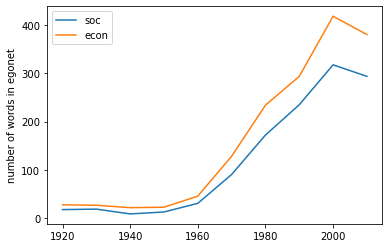

In [69]:
plt.plot(
    range(YMIN, YMAX, YWINDOW),
    np.sum(np.array(r['soc'])!=0, axis=1),
    label='soc'
)
plt.plot(
    range(YMIN, YMAX, YWINDOW),
    np.sum(np.array(r['econ'])!=0, axis=1),
    label='econ'
)
plt.ylabel("number of words in egonet")
plt.legend();

# econ

In [70]:
from scipy.spatial.distance import cosine

In [71]:
rels2 = get_tnets(cc_econ, focal)

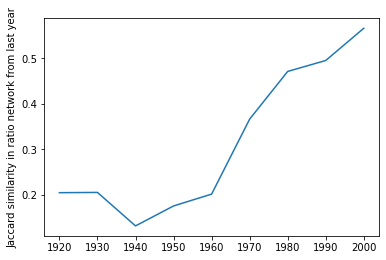

In [72]:
plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ ((a>0)&(b>0)).sum() / ((a>0)|(b>0)).sum() for a,b in zip(r['econ'][:-1], r['econ'][1:]) ]
)
plt.ylabel("Jaccard similarity in ratio network from last year");

# comparing econ to soc over time

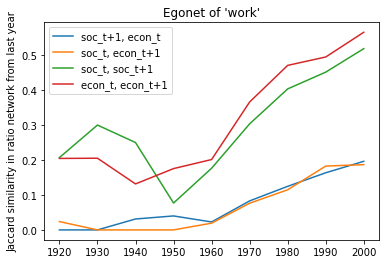

In [73]:
plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ ((a>0)&(b>0)).sum() / ((a>0)|(b>0)).sum() for a,b in zip(r['econ'][:-1], r['soc'][1:]) ],
    label='soc_t+1, econ_t'
)

plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ ((a>0)&(b>0)).sum() / ((a>0)|(b>0)).sum() for a,b in zip(r['soc'][:-1], r['econ'][1:]) ],
    label='soc_t, econ_t+1'
)

plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ ((a>0)&(b>0)).sum() / ((a>0)|(b>0)).sum() for a,b in zip(r['soc'][:-1], r['soc'][1:]) ],
    label='soc_t, soc_t+1'
)

plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ ((a>0)&(b>0)).sum() / ((a>0)|(b>0)).sum() for a,b in zip(r['econ'][:-1], r['econ'][1:]) ],
    label='econ_t, econ_t+1'
)

plt.ylabel("Jaccard similarity in ratio network from last year");
plt.title("Egonet of '%s'"%focal)
plt.legend();
plt.savefig('%s.ratios.crosstempjaccard.png'%focal)

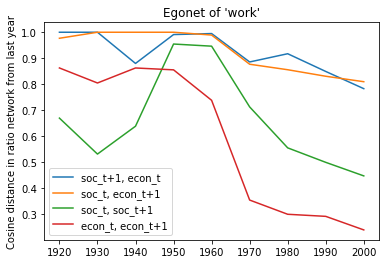

In [74]:
plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ cosine(a,b) for a,b in zip(r['econ'][:-1], r['soc'][1:]) ],
    label='soc_t+1, econ_t'
)

plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ cosine(a,b) for a,b in zip(r['soc'][:-1], r['econ'][1:]) ],
    label='soc_t, econ_t+1'
)

plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ cosine(a,b) for a,b in zip(r['soc'][:-1], r['soc'][1:]) ],
    label='soc_t, soc_t+1'
)

plt.plot(
    range(YMIN, YMAX-YWINDOW, YWINDOW),
    [ cosine(a,b) for a,b in zip(r['econ'][:-1], r['econ'][1:]) ],
    label='econ_t, econ_t+1'
)

plt.ylabel("Cosine distance in ratio network from last year");
plt.title("Egonet of '%s'"%focal)
plt.legend();
plt.savefig('%s.ratios.crosstempcosine.png'%focal)

## which words changed the most in terms of counts

In [47]:
def norm(x):
    return np.power( (x**2).sum(), 0.5 )

In [17]:
wdiff = rels_l[17] / norm(rels_l[17]) - rels_l[16] / norm(rels_l[16])

for w in np.argsort(wdiff)[::-1][:10]:
    print(terms[w], wdiff[w])

NameError: name 'rels_l' is not defined

In [ ]:
wdiff = rels_l[17] / norm(rels_l[17]) - rels_l[16] / norm(rels_l[16])

for w in np.argsort(wdiff)[::-1][:10]:
    print(terms[w], wdiff[w])

In [65]:
for w in np.argsort(-wdiff)[::-1][:10]:
    print(terms[w], -wdiff[w])

critique 0.33333333333333337
analysis 0.33333333333333337
nation 0.33333333333333337
survey 0.33333333333333337
state 0.33333333333333337
with 0.33333333333333337
western 0.17569668573457117
united 0.08348515814989957
states 0.08348515814989957
exploratory -0.0


In [ ]:
for w in np.argsort(-wdiff)[::-1][:10]:
    print(terms[w], -wdiff[w])